In [1]:
%load_ext lab_black

In [2]:
%matplotlib inline

from io import StringIO
from plotly.subplots import make_subplots
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
import requests
import time
import wget
import yfinance as yf
import warnings
import zipfile

warnings.filterwarnings("ignore")

### Latest data with Kats

In [3]:
BASE_URL = "https://fapi.binance.com/fapi/v1/klines?symbol={0}&limit=1000&interval={1}"
COLUMNS = [
    "Open_time",
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "Close_time",
    "Quote_asset_volume",
    "Number_of_trades",
    "Taker_buy_base_asset_volume",
    "Taker_buy_quote_asset_volume",
    "Ignore",
]

In [4]:
exchange_info = requests.request(
    "GET", "https://fapi.binance.com/fapi/v1/exchangeInfo", headers={}, data={}
)
all_pairs = [
    s["symbol"]
    for s in exchange_info.json()["symbols"]
    if (s["contractType"] == "PERPETUAL")
]

In [5]:
def realtime_tickers(symbol: str, interval: str) -> pd.DataFrame:
    response = requests.request(
        "GET", BASE_URL.format(symbol, interval), headers={}, data={}
    )

    df = pd.DataFrame(response.json(), columns=COLUMNS)
    df[[col for col in COLUMNS if "time" not in col]] = df[
        [col for col in COLUMNS if "time" not in col]
    ].apply(pd.to_numeric)
    df["Close_time"] = pd.to_datetime(df["Close_time"], unit="ms") + pd.Timedelta(
        "07:00:00"
    )
    df["Open_time"] = pd.to_datetime(df["Open_time"], unit="ms") + pd.Timedelta(
        "07:00:00"
    )
    df.sort_values(by="Close_time", ascending=False, inplace=True)

    return df

In [6]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 150

In [7]:
from kats.consts import TimeSeriesData

price_df = realtime_tickers(symbol="BTCUSDT", interval="15m").head(200)[
    ["Close_time", "Close"]
]
price_df.columns = ["time", "y"]

data = TimeSeriesData(price_df)

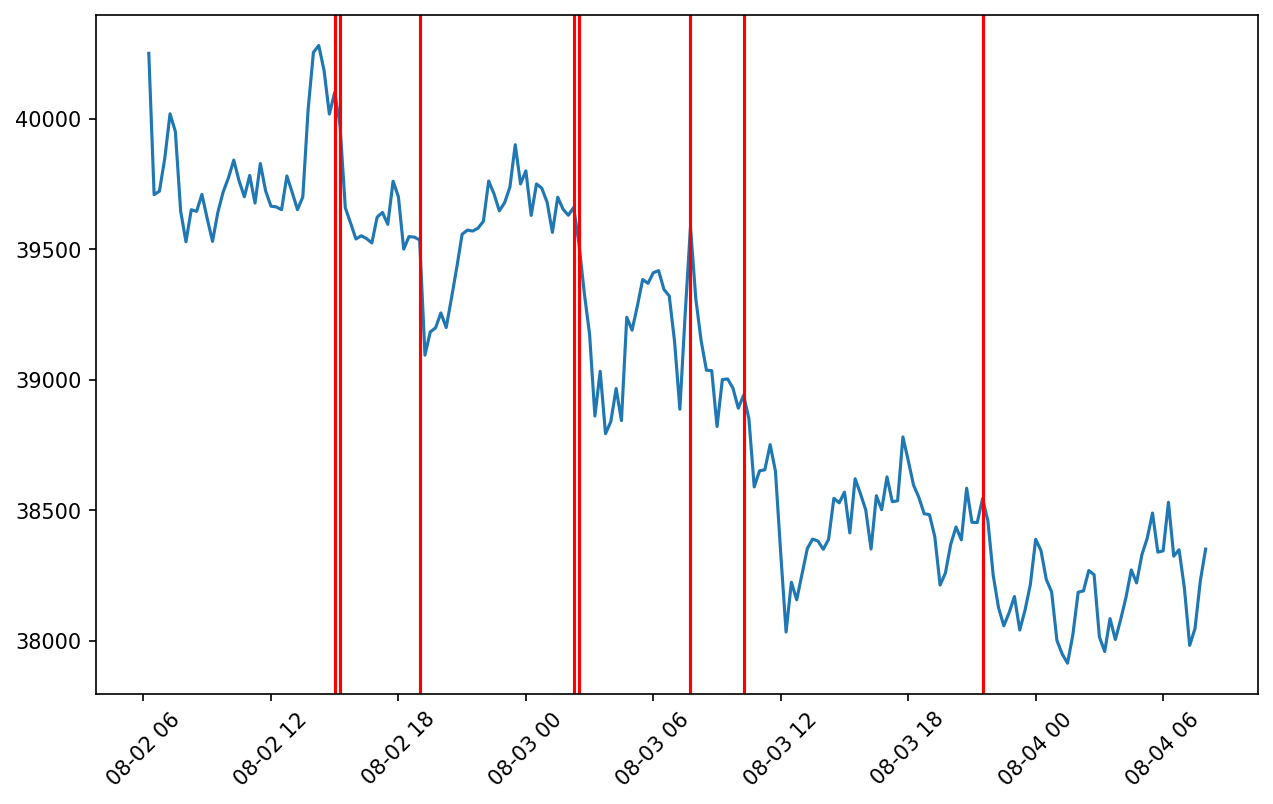

In [8]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType

detector = BOCPDetector(data)

changepoints = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, lag=32, threshold=0.8
)

plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

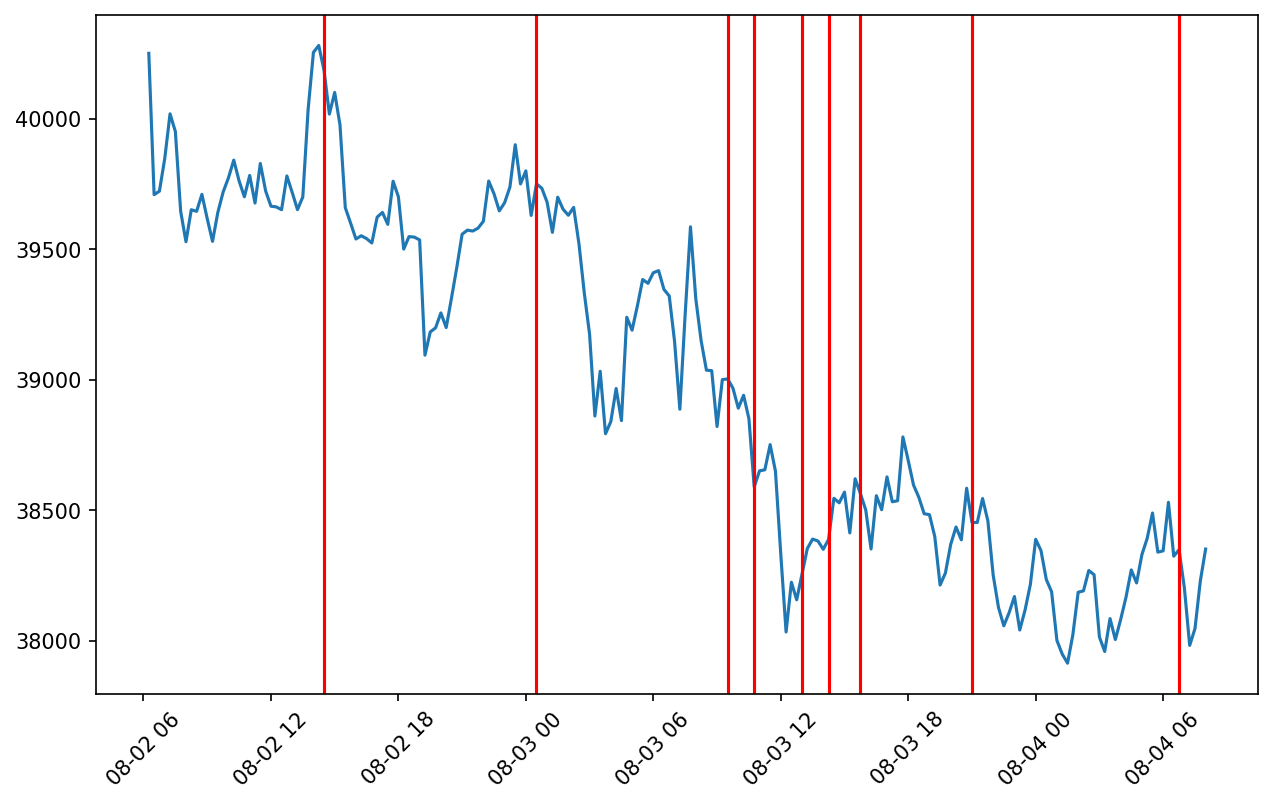

In [9]:
from kats.detectors.robust_stat_detection import RobustStatDetector

detector = RobustStatDetector(data)
changepoints = detector.detector(p_value_cutoff=0.075, comparison_window=32)

plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

### Backtest
#### All intervals are supported: 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1mo

In [ ]:
BASE_URL = "https://data.binance.vision/data/spot/monthly/klines/{0}/{1}/"
COLUMNS = [
    "Open_time",
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "Close_time",
    "Quote_asset_volume",
    "Number_of_trades",
    "Taker_buy_base_asset_volume",
    "Taker_buy_quote_asset_volume",
    "Ignore",
]

In [ ]:
def get_tickers(symbol: str, year: int, month: int, interval: str) -> pd.DataFrame:
    if not os.path.exists("./data"):
        os.mkdir("./data")

    filename = "{0}-{1}-{2}-{3}.zip".format(symbol, interval, year, str(month).zfill(2))
    filepath = "./data/" + filename
    if not os.path.exists(filepath):
        wget.download(
            BASE_URL.format(symbol, interval) + filename,
            out=filepath,
        )

    df = pd.read_csv(filepath, header=None, names=COLUMNS)
    df["Close_time"] = pd.to_datetime(df["Close_time"], unit="ms")
    df["Open_time"] = pd.to_datetime(df["Open_time"], unit="ms")

    return df

#### Scan multiple timeframe

In [ ]:
cpd = dict()
for interval in ["1h", "4h", "1d"]:
    df = get_tickers(symbol="ETHUSDT", year=2021, month=5, interval=interval)

    bc = bocd.BayesianOnlineChangePointDetection(
        bocd.ConstantHazard(300), bocd.StudentT(mu=0, kappa=1, alpha=1, beta=1)
    )

    rt_mle = np.empty(df["Close"].values.shape)
    for i, d in enumerate(df["Close"].values):
        bc.update(d)
        rt_mle[i] = bc.rt

    cpd[interval] = df.iloc[np.where(np.diff(rt_mle) < 0)][["Open_time", "Close_time"]]

In [ ]:
supports = list()
for _, row in cpd["1h"].iterrows():
    matches = list()
    for interval in ["4h", "1d"]:
        match = cpd[interval].loc[
            (cpd[interval]["Open_time"] <= row["Open_time"])
            & (cpd[interval]["Close_time"] >= row["Close_time"])
        ]
        if not match.empty:
            matches.append(interval)
    if len(matches) > 0:
        supports.append((row, matches))

In [ ]:
[s for s in supports if len(s[1]) >= 1]

### OHLC plot

In [ ]:
price_df = get_tickers(symbol="ETHUSDT", year=2021, month=5, interval="1h")

In [ ]:
signals = price_df["Close"].values
dates = price_df["Close_time"].values

In [ ]:
# Initialize object
bc = bocd.BayesianOnlineChangePointDetection(
    bocd.ConstantHazard(300), bocd.StudentT(mu=0, kappa=1, alpha=1, beta=1)
)

# Online estimation and get the maximum likelihood r_t at each time point
rt_mle = np.empty(signals.shape)
for i, d in enumerate(signals):
    bc.update(d)
    rt_mle[i] = bc.rt

# Project predictions on price
index_changes = np.where(np.diff(rt_mle) < 0)[0]
signal_changes = np.array(
    [None if i not in index_changes else v for i, v in enumerate(signals)]
)

In [ ]:
####################################
#        OHLC Plot with CPD        #
####################################
candle_fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    subplot_titles=("CPD", "OHLC"),
)

candle_fig.add_trace(
    go.Scatter(x=dates, y=signals, mode="lines", name="price"),
    row=1,
    col=1,
)
candle_fig.add_trace(
    go.Scatter(x=dates, y=signal_changes, mode="markers", name="cp"),
    row=1,
    col=1,
)

candle_fig.add_trace(
    go.Candlestick(
        x=dates,
        open=price_df["Open"],
        high=price_df["High"],
        low=price_df["Low"],
        close=price_df["Close"],
        name="OHLC",
    ),
    row=2,
    col=1,
)

candle_fig.update_layout(
    autosize=False,
    width=1400,
    height=700,
    margin=dict(l=10, r=10, b=20, t=40, pad=20),
    paper_bgcolor="LightSteelBlue",
)
candle_fig.show()